In [1]:
import transformers
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from koeda import EDA, RD, RI, RS, SR
from transformers import AutoModel
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [9]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
LM1 = AutoModelForSequenceClassification.from_pretrained('jihoonkimharu/bert-base-klue-ynat-finetuned').to(DEVICE)
LM2 = AutoModelForSequenceClassification.from_pretrained('yobi/klue-roberta-base-ynat').to(DEVICE)
LM3 = AutoModelForSequenceClassification.from_pretrained('ehddnr301/bert-base-ehddnr-ynat').to(DEVICE)
LM4 = AutoModelForSequenceClassification.from_pretrained('bash1130/bert-base-finetuned-ynat').to(DEVICE)
tokenizer1 = AutoTokenizer.from_pretrained('jihoonkimharu/bert-base-klue-ynat-finetuned')
tokenizer2 = AutoTokenizer.from_pretrained('yobi/klue-roberta-base-ynat')
tokenizer3 = AutoTokenizer.from_pretrained('ehddnr301/bert-base-ehddnr-ynat')
tokenizer4 = AutoTokenizer.from_pretrained('bash1130/bert-base-finetuned-ynat')

In [6]:
def inference(model1, model2, model3, model4, data, tokenizer1, tokenizer2, tokenizer3, tokenizer4, DEVICE):
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    preds = []
    
    print('data length:', len(data))
    
    for idx, sample in tqdm(data.iterrows()):
        inputs1 = tokenizer1(sample['text'], return_tensors="pt").to(DEVICE)
        inputs2 = tokenizer2(sample['text'], return_tensors="pt").to(DEVICE)
        inputs3 = tokenizer3(sample['text'], return_tensors="pt").to(DEVICE)
        inputs4 = tokenizer4(sample['text'], return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            logits1 = model1(**inputs1).logits
            logits2 = model2(**inputs2).logits
            logits3 = model3(**inputs3).logits
            logits4 = model4(**inputs4).logits
            logits = logits1 + logits2 + logits3 + logits4
            pred = torch.argmax(torch.nn.Softmax(dim=1)(logits), dim=1).cpu().numpy()
            preds.extend(pred)

    return preds

0.8358292549303711




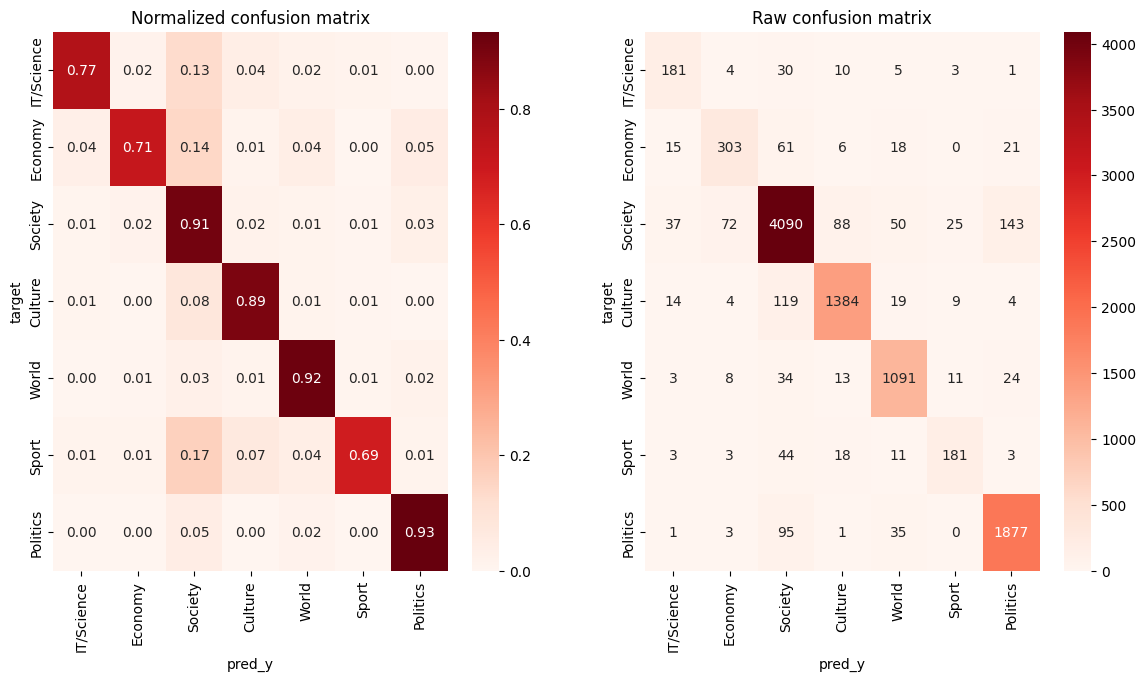

In [46]:
temp = pd.read_csv('../results/01134902-cleaned_1920_YTN_labeladdLM_v1/01134902-cleaned_1920_YTN_labeladdLM_v1_val.csv')
print(f1_score(y_true = temp['target'], y_pred = temp['pred_y'], average = 'macro'))
print()
print()
cm = confusion_matrix(y_true = temp['target'], y_pred = temp['pred_y'])

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))


sns.heatmap(cmn, cmap='Reds', annot=True, fmt='.2f', xticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], 
            yticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], ax=ax1)
ax1.set_ylabel('target')
ax1.set_xlabel('pred_y')
ax1.set_title('Normalized confusion matrix')


sns.heatmap(cm, cmap='Reds', annot=True, fmt='d', xticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], 
            yticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], ax=ax2)
ax2.set_ylabel('target')
ax2.set_xlabel('pred_y')
ax2.set_title('Raw confusion matrix')

plt.show(block=False)

In [47]:
wrong_df = temp[temp['target'] != temp['pred_y']]

In [48]:
len(wrong_df)

1068

In [49]:
wrong_df['text'].head(5)

6                  항일 외치는 조국 SNS에 일본어 글 올려
8          게임 중독 질병으로 봐야할까...찬성 여론 반대보다 높아
28            강성범 원정 불법 도박 의혹 제기...사실무근 입장
49    프듀X101 투표수 리셋 김우석 1위...김요한 5위 순위 대변동
54          아비가일 저 결혼해요...1월4일 군인 남자친구와 결혼
Name: text, dtype: object

In [50]:
eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, prob_rd=0.1
)

sen_after_EDA = eda(wrong_df['text'].to_list())

In [54]:
eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, prob_rd=0.1
)
eda('‘뭉쳐야 찬다’ 전설들의 투혼, 첫 대회 3위 값진 결실"')

'‘뭉쳐야 찬다’ 전설,의 투혼들 첫 대회 3위 값진 결실"'

In [51]:
sen_after_EDA[:5]

['항일 외치는 조국 유물 SNS에 일본어 글 올려',
 '게임중독 질병으로 봐야할까...찬성 여론 반대보다 높아',
 '불법 도박 의혹 제기...사실무근 입장',
 '프듀X 투표수 리셋 김우석 1위...김요한 5 순위 대변동',
 '아비가일 호각 결혼해요...1월4일 군인 남자친구와 결혼']

In [52]:
wrong_df['text'] = sen_after_EDA

/tmp/ipykernel_16114/773237323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_df['text'] = sen_after_EDA


In [53]:
wrong_df.head(5)

,label_text,text,target,track,pred_y
6,정치,항일 외치는 조국 유물 SNS에 일본어 글 올려,6,cleaned_1920_YTN_labeladdLM_v1,2
8,사회,게임중독 질병으로 봐야할까...찬성 여론 반대보다 높아,0,cleaned_1920_YTN_labeladdLM_v1,2
28,세계,불법 도박 의혹 제기...사실무근 입장,5,cleaned_1920_YTN_labeladdLM_v1,2
49,생활문화,프듀X 투표수 리셋 김우석 1위...김요한 5 순위 대변동,5,cleaned_1920_YTN_labeladdLM_v1,2
54,생활문화,아비가일 호각 결혼해요...1월4일 군인 남자친구와 결혼,2,cleaned_1920_YTN_labeladdLM_v1,3


In [54]:
wrong_df = wrong_df.drop(['label_text', 'pred_y', 'track'], axis=1)
wrong_df.to_csv('../data/YTN_wrong_EDA_aug.csv')

In [41]:
label2num = {'IT과학':0,
             '경제':1,
             '사회':2,
             '생활문화':3,
             '세계':4,
             '스포츠':5,
             '정치':6}
num2label = list(label2num.keys())

In [35]:
wrong_df.columns

Index(['ID', 'text', 'target', 'track', 'pred_y'], dtype='object')

In [36]:
wrong_df = wrong_df.drop(['ID', 'track'], axis=1)
wrong_df['target'] = wrong_df['target'].apply(lambda x:num2label[x])
wrong_df['pred_y'] = wrong_df['pred_y'].apply(lambda x:num2label[x])
wrong_df.to_csv('wrong_df_train.csv', index=False)

,text,target,pred_y
10,스마트폰 없이 못사는 대한민국…60대 10%가 중독위험,IT과학,사회
22,네이마르바르사 소송전에도…MSN 트리오는 화기애애,스포츠,세계
33,고침문화수어영상 크기·위치 맘대로…,사회,생활문화
42,올림픽 평창 계촌5리 작은 마을서 지구촌 화합 파티,스포츠,생활문화
66,EBS 상업출판 교육·출판 양면에서 공공성 저해,사회,생활문화
...,...,...,...
13641,유영민 과기장관 과학 RD 예산 19조…큰 그림 보여줘야,IT과학,정치
13660,생방송 앱 단속 철저히 해라 中 규제당국 애플 소환 예정,IT과학,사회
13683,게시판 NHN엔터 추석맞이 보드게임 4종 경품행사,경제,생활문화
13687,대한항공 인천∼바르셀로나 노선 첫 취항,경제,생활문화
